In [1]:
!date

Wed Feb 12 10:08:21 PST 2020


# Level 1 Analysis

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
isoform = anndata.read_h5ad("cell_ranger_annotation/isoform.h5ad")
gene =    anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Restrict analysis to two isoform genes

In [3]:
gene

AnnData object with n_obs × n_vars = 6043 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [4]:
isoform

AnnData object with n_obs × n_vars = 6043 × 84364 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'gene_TPM', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'

In [5]:
gene_id = gene.var["gene_id"].values
gene_names = gene.var["gene_name"].values.astype(str)
ngenes = gene_names.shape[0]
ncells = gene.shape[0]

In [6]:
clusters = gene.obs["subclass_label"].unique().astype(str)
nclusters = clusters.shape[0]

In [7]:
clusters

array(['Vip', 'L5 IT', 'Lamp5', 'Sst', 'L5/6 NP', 'Pvalb', 'L2/3 IT',
       'L6 IT', 'L6 CT', 'L6b', 'L5 ET', 'Sncg', 'Low Quality',
       'L6 IT Car3', 'SMC', 'VLMC', 'Astro', 'Endo'], dtype='<U11')

In [8]:
gene_names

array(['Xkr4', 'Gm1992', 'Gm37381', ..., 'AC149090.1', 'CAAA01118383.1',
       'CAAA01147332.1'], dtype='<U14')

## Now do t-test between isoform shifts in clusters

In [418]:
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ks_2samp, ttest_ind
import numpy as np
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')



def split_by_target(mat, targets, target, axis=0):
    """
    Split the rows of mat by the proper assignment
    
    mat = ndarray
    targets, length is equal to number of components (axis=0) or features (axis=1)
    target is a singular element from unique(assignments/features) 
    """
    if axis==0 and len(targets) != mat.shape[axis]: return -1
    if axis==1 and len(targets) != mat.shape[axis]: return -1
        
    mask = targets == target
    
    if axis==0:
        t_mat = mat[mask]  # target matrix
        c_mat = mat[~mask] # complement matrix
    elif axis==1:
        t_mat = mat[:, mask]  # target matrix
        c_mat = mat[:, ~mask] # complement matrix
    
    return (t_mat, c_mat)

def correct_pval(pval, method):
    nfeat = pval.shape[1]
    
    if method == 'benjamini-hochberg':
        _, pval_corr, _, _ = multipletests(pval, alpha=0.05, method='fdr_bh')
    elif method == 'bonferroni':
        pval_corr = np.minimum(pval * nfeat, 1.0)
        
    return pval_corr

def dexpress(mat, components, features, assignments, **kwargs):
    """
    mat: ndarray
    components: nparray
    features: nparray
    assignments: nparray, length is equal to length of components
    """
    nan_cutoff = kwargs.get("nan_cutoff", 0)
    corr_method = kwargs.get("corr_method", "bonferroni")
    
    unique = np.unique(assignments)
        
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    pval = np.empty((nuniq, nfeat)) # unique assignments by features 
    pval_corr = np.empty((nuniq, nfeat)) # unique assignments by features 
    stat = np.empty((nuniq, nfeat)) # unique assignments by features 
    
    pval.fill(np.nan)
    pval_corr.fill(np.nan)
    stat.fill(np.nan)

    for tidx, t in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(tidx+1, nuniq, t))
        t_mat, c_mat = split_by_target(mat, assignments, t, axis=0)
        
        
        pvalue = np.nan
        statistic = np.nan

        # Keep only the genes for which it is in at least nan_cutoff*ncellsinclusters
        mask = np.asarray((t_mat>0).sum(axis=0) > nan_cutoff*t_mat.shape[0]).reshape(-1)

        # tmp_t_mat = t_mat[:, mask]
        # tmp_c_mat = c_mat[:, mask]
        # added
        bool_list = [True]*t_mat.shape[1]
        stat_mask = np.bool(bool_list)
        # added
        if mask.sum()>0:
            test = ttest_ind(t_mat, c_mat, nan_policy="propagate")
            pvalue = test.pvalue/2
            statistic = test.statistic
            stat_mask = (statistic>1) # >0 enrichment, <0 depletion

        m = np.logical_and(mask, stat_mask)
        pval[tidx,:][m] = pvalue[m]
        stat[tidx,:][m] = statistic[m]

    pval_corr = correct_pval(pval, corr_method)
    
    return (pval, pval_corr, stat)

In [419]:
%%time
nc = 10
nf = 10

mat         = gene.layers["log1p"][:nc,:nf]
components  = gene.obs.cell_id.values[:nc]
features    = gene.var.gene_name.values[:nf]
assignments = gene.obs.subclass_label.values[:nc]

# %lprun -f dexpress dexpress(mat, components, features, assignments)
pval, pval_corr, stat = dexpress(mat, components, features, assignments)

26-Feb-20 13:30:58 - 1 of 5 assignments: L5 IT
26-Feb-20 13:30:58 - 2 of 5 assignments: L5/6 NP
26-Feb-20 13:30:58 - 3 of 5 assignments: Lamp5
26-Feb-20 13:30:58 - 4 of 5 assignments: Sst
26-Feb-20 13:30:58 - 5 of 5 assignments: Vip


CPU times: user 9.98 ms, sys: 938 µs, total: 10.9 ms
Wall time: 8.75 ms


In [420]:
print(pval)

[[       nan        nan 0.03216495        nan        nan        nan
         nan        nan        nan 0.03564116]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]
 [       nan 0.06547332        nan        nan        nan 0.06487842
  0.12958264 0.06640056        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan]]


# T-test on all genes

In [270]:
%%time
mat         = gene.layers["log1p"]
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


pval, pval_corr, stat = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

25-Feb-20 13:51:08 - 1 of 18 assignments: Astro
25-Feb-20 13:51:09 - 2 of 18 assignments: Endo
25-Feb-20 13:51:09 - 3 of 18 assignments: L2/3 IT
25-Feb-20 13:51:10 - 4 of 18 assignments: L5 ET
25-Feb-20 13:51:11 - 5 of 18 assignments: L5 IT
25-Feb-20 13:51:11 - 6 of 18 assignments: L5/6 NP
25-Feb-20 13:51:12 - 7 of 18 assignments: L6 CT
25-Feb-20 13:51:13 - 8 of 18 assignments: L6 IT
25-Feb-20 13:51:13 - 9 of 18 assignments: L6 IT Car3
25-Feb-20 13:51:14 - 10 of 18 assignments: L6b
25-Feb-20 13:51:14 - 11 of 18 assignments: Lamp5
25-Feb-20 13:51:15 - 12 of 18 assignments: Low Quality
25-Feb-20 13:51:16 - 13 of 18 assignments: Pvalb
25-Feb-20 13:51:16 - 14 of 18 assignments: SMC
25-Feb-20 13:51:17 - 15 of 18 assignments: Sncg
25-Feb-20 13:51:18 - 16 of 18 assignments: Sst
25-Feb-20 13:51:18 - 17 of 18 assignments: VLMC
25-Feb-20 13:51:19 - 18 of 18 assignments: Vip


CPU times: user 7.19 s, sys: 4.03 s, total: 11.2 s
Wall time: 11.2 s


In [271]:
%%time
mat         = isoform.layers["log1p"].todense() # expects dense matrix
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"

pval_iso, pval_iso_corr, stat_iso = dexpress(mat, components, 
                                             features, assignments, 
                                             corr_method=corr_method, 
                                              nan_cutoff=nan_cutoff)

25-Feb-20 13:51:34 - 1 of 18 assignments: Astro
25-Feb-20 13:51:43 - 2 of 18 assignments: Endo
25-Feb-20 13:51:52 - 3 of 18 assignments: L2/3 IT
25-Feb-20 13:51:59 - 4 of 18 assignments: L5 ET
25-Feb-20 13:52:08 - 5 of 18 assignments: L5 IT
25-Feb-20 13:52:15 - 6 of 18 assignments: L5/6 NP
25-Feb-20 13:52:23 - 7 of 18 assignments: L6 CT
25-Feb-20 13:52:30 - 8 of 18 assignments: L6 IT
25-Feb-20 13:52:39 - 9 of 18 assignments: L6 IT Car3
25-Feb-20 13:52:48 - 10 of 18 assignments: L6b
25-Feb-20 13:52:56 - 11 of 18 assignments: Lamp5
25-Feb-20 13:53:04 - 12 of 18 assignments: Low Quality
25-Feb-20 13:53:12 - 13 of 18 assignments: Pvalb
25-Feb-20 13:53:20 - 14 of 18 assignments: SMC
25-Feb-20 13:53:29 - 15 of 18 assignments: Sncg
25-Feb-20 13:53:37 - 16 of 18 assignments: Sst
25-Feb-20 13:53:45 - 17 of 18 assignments: VLMC
25-Feb-20 13:53:54 - 18 of 18 assignments: Vip


CPU times: user 36.5 s, sys: 1min 53s, total: 2min 29s
Wall time: 2min 29s


In [272]:
unique

array(['Astro', 'Endo', 'L2/3 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT',
       'L6 IT', 'L6 IT Car3', 'L6b', 'Lamp5', 'Low Quality', 'Pvalb',
       'SMC', 'Sncg', 'Sst', 'VLMC', 'Vip'], dtype=object)

In [273]:
def print_top_features(features, unique, pval, return_pvals=False, cnum=-1):
    log10p = -np.log10(pval[cnum])
    
    alpha = -np.log10(0.05)
    
    mask = np.logical_and(~np.isnan(log10p), log10p>alpha)
    if mask.sum()==0:
            return []
    psort = np.argsort(log10p[mask])

    # Sorted in ascending order of -log10pval(smallest=last)
    if return_pvals == True:
        return pval[cnum][mask][psort]
    top_features = features[mask][psort]
    return top_features

In [274]:
%%time
features    = gene.var.gene_name.values
assignments = gene.obs.subclass_label.values

unique = np.unique(assignments)

print_top_features(features, unique, pval_corr, cnum=-1)[-10:]

CPU times: user 8.31 ms, sys: 335 µs, total: 8.64 ms
Wall time: 7.4 ms


[Dlx6os1, Vip, Cd63, Gad1, Zfp536, Dlx1, Cpne7, Adarb2, Igf1, Prox1]
Categories (20568, object): [0610005C13Rik, 0610009B22Rik, 0610009O20Rik, 0610010F05Rik, ..., mt-Nd4, mt-Nd4l, mt-Nd5, mt-Nd6]

In [275]:
from collections import defaultdict

In [290]:
d = defaultdict()
ng = 30
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
gene_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
gene_pvals = pd.DataFrame(d, index=unique)

In [291]:
mat         = gene.X
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.subclass_label.values

unique = np.unique(assignments)

for cidx, c in enumerate(unique):
    print(c)
    markers = print_top_features(features, unique, pval_corr, cnum=cidx)[::-1]
    if markers.shape[0] < ng: markers = np.append(markers, [np.nan]*(ng-markers.shape[0]))
    elif markers.shape[0]>ng: markers = markers[:ng]
    gene_markers.loc[c] = markers

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Low Quality
Pvalb
SMC
Sncg
Sst
VLMC
Vip


In [292]:
gene_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29
Astro,Lrp4,Mt1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Endo,Slco1a4,Hspb1,Ly6c1,Slco1c1,Cldn5,S1pr1,Ifitm3,Srgn,Cyyr1,Icam2,...,Flt1,Nostrin,Pltp,Ctsh,Tek,Sparc,Id1,Tm4sf1,S100a13,Selenop
L2/3 IT,Prex1,Tmem215,Calb1,Fam19a1,Wfs1,Frzb,Myh7,Palmd,Pou3f1,Stard8,...,Lhx2,Enpp2,Meis2,Kctd4,Cux2,Gm20063,Dgkb,Lifr,Slit3,Gpr88
L5 ET,Npr3,Fam84b,Layn,Chst8,Cox7a1,Adam18,Klhl1,Tekt5,Pou3f1,Kcng1,...,B3galt5,Amn,Gm30648,Sgpp2,Tanc1,Gm48597,Bcl6,AC154509.1,Coro6,Fam126a
L5 IT,Epha4,Kcnv1,Dnajc21,AC124561.1,Cdh12,Wls,Ankrd33b,Lingo1,Lamp5,Mapk4,...,C730002L08Rik,Lxn,Rtn4rl1,Coch,Fstl4,Pamr1,Dtl,Slc30a3,Bdnf,Cobl
L5/6 NP,Vwc2l,Tshz2,Stard5,Etv1,Il11ra1,Lhfpl5,Nxph3,Lypd1,Efr3a,Rnf152,...,Trpc3,Slit1,Sec62,Plcxd2,Tmem159,Chn2,Ccl27,Dusp5,Pamr1,Cpne4
L6 CT,Zfpm2,Rprm,Tle4,Cdh9,Myl4,Sema5a,Nfia,Ddah1,Pla2g4b,Igsf21,...,Ighm,Fancd2,Arhgap25,Ramp3,Ccdc12,Nrp1,Col12a1,Gadd45a,Garnl3,Ccl27
L6 IT,Gm2694,Plekha2,Bmp3,Tenm3,Sulf1,Blnk,Col6a1,Cdh9,Ptpru,Pter,...,Igsf21,Matn2,Stum,Cpne5,Igfbp6,Slit3,Gnb4,Slc9b2,Trp53i11,Nov
L6 IT Car3,Car3,Vgll2,Slfn2,Gm45623,Gm16277,Itpkb,Col11a1,Oprk1,Col24a1,Cbln1,...,CK137956,Cntnap3,Rgs12,Angpt1,Aard,Gm32647,Tmem163,Itga8,Cpne4,Gm17669
L6b,Drd1,Nxph3,Cplx3,Ly6g6e,Pcsk5,Gng12,Tmem163,Ctgf,Glra2,Prss12,...,Bag1,Cd164,Phyhipl,Cdh18,Chrna4,Tmem91,Sema5a,Bend5,Gadd45a,Tmem243


In [293]:
%%time
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)

print_top_features(features, unique, pval_iso_corr, cnum=-1)[-10:]

CPU times: user 9.6 ms, sys: 0 ns, total: 9.6 ms
Wall time: 8.57 ms


array(['Ap1s2-202', 'Gad1-201', 'Gad1-206', 'Adarb2-206', 'Synpr-201',
       'Igf1-202', 'Vip-201', 'Cd63-201', 'Adarb2-203', 'Dlx1-203'],
      dtype=object)

In [294]:
d = defaultdict()
ng = 30
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
isoform_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
isoform_pvals = pd.DataFrame(d, index=unique)

In [295]:
mat         = isoform.X
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

unique = np.unique(assignments)

for cidx, c in enumerate(unique):
    print(c)
    markers = print_top_features(features, unique, pval_iso_corr, cnum=cidx)[::-1]
    if markers.shape[0] < ng: markers = np.append(markers, [np.nan]*(ng-markers.shape[0]))
    elif markers.shape[0]>ng: markers = markers[:ng]
    isoform_markers.loc[c] = markers

Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6 IT Car3
L6b
Lamp5
Low Quality
Pvalb
SMC
Sncg
Sst
VLMC
Vip


In [296]:
isoform_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29
Astro,Mt1-201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Endo,Ifitm3-201,Ly6a-201,Selenop-203,Wfdc1-201,Zfp36l1-201,Tek-202,Abcb1a-201,Hspb1-201,Flt1-202,Icam2-201,...,Srgn-201,Emcn-204,Cyba-201,Ly6c1-201,Egfl7-202,Pltp-204,Ly6c1-202,S100a16-201,Ccdc141-204,S1pr1-201
L2/3 IT,Stard8-201,Arpp21-206,Palmd-201,Myh7-201,Fam19a1-204,Fam19a1-202,Enpp2-204,Enpp2-207,Frzb-201,Calb1-201,...,Rasgrf2-205,A830009L08Rik-201,Slit3-201,Pdp1-205,Tpm1-205,Lamp5-202,Enpp2-201,Neurod1-201,Lhx2-201,Lifr-203
L5 ET,Npr3-201,Layn-204,Layn-201,Fam84b-201,Chst8-204,Chst8-201,Hsd11b1-201,Cox7a1-201,Magi2-210,Tanc1-210,...,Il11ra1-201,Hsd11b1-205,Kcng2-201,Snrpn-202,Amn-202,Pde9a-201,Sgpp2-201,Kcnn2-208,Haghl-211,Gm48597-201
L5 IT,Arhgap15-201,B2m-201,Fmnl1-201,Camkk2-201,S100a10-201,Cnih3-201,Kcnv1-201,Arpp21-218,Mical2-205,Plcxd2-201,...,Kalrn-206,A830036E02Rik-202,Cck-205,Extl3-201,A830036E02Rik-203,Ptprk-201,A430027H14Rik-201,Lin7a-201,St6galnac5-201,Htr2a-201
L5/6 NP,Etv1-201,Tshz2-202,Il11ra1-201,Il11ra1-202,Etv1-212,Il11ra1-204,Fezf2-203,Myl4-204,Stxbp2-207,Lhfpl5-201,...,Olfm3-201,Tmem159-201,Ccdc12-210,Plcxd2-201,Trp53i11-201,Sec62-201,Chn2-202,Gm13306-202,Ccl27-201,Dusp5-201
L6 CT,Ppp1r1b-201,Igsf21-201,Nxph3-201,Ddah1-201,Gm13306-203,Ramp3-201,Ccdc12-210,Prss23-204,Nrp1-201,Ppp1r1b-202,...,Myl4-204,Pde4d-211,Pde4d-209,Ighm-201,Cdh9-202,H2-T23-201,Igfbp4-203,Sema5a-201,Pla2g4b-205,Rprm-201
L6 IT,Tpm1-216,Gm2694-207,Bmp3-201,Blnk-201,Blnk-202,Erc2-207,Cdh9-202,Col6a1-201,Ptpru-207,Tesc-203,...,Cpne5-205,Cpne5-201,Stum-201,Igsf21-201,Slit3-201,Igfbp6-201,Erc2-208,Nov-201,Cryab-204,Crtac1-201
L6 IT Car3,Gm32647-201,Car3-202,Cpne4-204,Arhgef6-204,Gfra1-201,Synpr-205,Oprk1-204,Slfn2-201,Col11a1-201,Cbln1-201,...,Cmbl-204,Col24a1-201,Nr4a2-201,Cmbl-201,Lepr-203,Rgs12-206,Smoc2-201,Gnb4-205,Cpne4-201,Angpt1-201
L6b,Cplx3-201,Ly6g6e-201,Nxph3-201,Gng12-207,Gng12-201,Pcsk5-202,Ctgf-201,Glra2-201,Prss12-201,Atp6ap1l-201,...,Hpcal1-201,Serpini1-201,Cd164-201,Chrna4-201,Olfm3-201,Serpini1-203,Rcan2-201,Tle4-201,Tmem91-201,Sema5a-201


(84364,)

In [341]:
def split_iso(x):
    try:
        r = x.split("-")[0]
    except:
        r = "nan"
    return r

In [345]:
tst = []
for cidx, c in enumerate(unique[::-1]):
    g1 = gene_markers.loc[c].values.astype('<U21')
    
    g1 = g1[g1!='nan']    
    
    g2 = isoform_markers.loc[c].apply(split_iso).astype('<U21')
    g2 = g2[g2!="nan"]
    tst = tst + np.setdiff1d(g2, g1).tolist()
    if "Igfbp4" in tst:
        print(c)
    #print(c, "\t", np.setdiff1d(g2, g1).tolist())

L6 CT
L5/6 NP
L5 IT
L5 ET
L2/3 IT
Endo
Astro


In [177]:
"Kalrn-206" is glut marker
Dlx1 Slc6a1 Slc32a1 also "Gad2" marker for gabaergic

SyntaxError: invalid syntax (<ipython-input-177-e1da61a2979c>, line 1)

# Test on clusters (smallest ones!)

In [399]:
l5gene = gene[gene.obs.subclass_label=="L5 IT"] 
l5iso = isoform[isoform.obs.subclass_label=="L5 IT"]

In [421]:
%%time
mat         = l5gene.layers["log1p"]
components  = l5gene.obs.cell_id.values
features    = l5gene.var.gene_name.values
assignments = l5gene.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


pval, pval_corr, stat = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

26-Feb-20 13:31:10 - 1 of 7 assignments: L5 IT Pld5
26-Feb-20 13:31:10 - 2 of 7 assignments: L5 IT Rspo1
26-Feb-20 13:31:10 - 3 of 7 assignments: L5 IT Rspo2
26-Feb-20 13:31:10 - 4 of 7 assignments: L5 IT S100b_1
26-Feb-20 13:31:10 - 5 of 7 assignments: L5 IT S100b_2
26-Feb-20 13:31:11 - 6 of 7 assignments: L5 IT Tcap_1
26-Feb-20 13:31:11 - 7 of 7 assignments: L5 IT Tcap_2


CPU times: user 815 ms, sys: 430 ms, total: 1.25 s
Wall time: 1.24 s


In [422]:
%%time
mat         = l5iso.layers["log1p"].todense() # expects dense matrix
components  = l5iso.obs.cell_id.values
features    = l5iso.var.transcript_name.values
assignments = l5iso.obs.cluster_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"

pval_iso, pval_iso_corr, stat_iso = dexpress(mat, components, 
                                             features, assignments, 
                                             corr_method=corr_method, 
                                              nan_cutoff=nan_cutoff)

26-Feb-20 13:31:12 - 1 of 7 assignments: L5 IT Pld5
26-Feb-20 13:31:12 - 2 of 7 assignments: L5 IT Rspo1
26-Feb-20 13:31:13 - 3 of 7 assignments: L5 IT Rspo2
26-Feb-20 13:31:14 - 4 of 7 assignments: L5 IT S100b_1
26-Feb-20 13:31:15 - 5 of 7 assignments: L5 IT S100b_2
26-Feb-20 13:31:15 - 6 of 7 assignments: L5 IT Tcap_1
26-Feb-20 13:31:16 - 7 of 7 assignments: L5 IT Tcap_2


CPU times: user 3.77 s, sys: 2.07 s, total: 5.84 s
Wall time: 5.84 s


In [423]:
unique

array(['L5 IT Pld5', 'L5 IT Rspo1', 'L5 IT Rspo2', 'L5 IT S100b_1',
       'L5 IT S100b_2', 'L5 IT Tcap_1', 'L5 IT Tcap_2'], dtype=object)

In [424]:
def print_top_features(features, unique, pval, return_pvals=False, cnum=-1):
    log10p = -np.log10(pval[cnum])
    
    alpha = -np.log10(0.05)
    
    mask = np.logical_and(~np.isnan(log10p), log10p>alpha)
    if mask.sum()==0:
            return []
    psort = np.argsort(log10p[mask])

    # Sorted in ascending order of -log10pval(smallest=last)
    if return_pvals == True:
        return pval[cnum][mask][psort]
    top_features = features[mask][psort]
    return top_features

In [425]:
%%time
features    = l5gene.var.gene_name.values
assignments = l5gene.obs.cluster_label.values

unique = np.unique(assignments)

print_top_features(features, unique, pval_corr, cnum=-1)[-10:]

CPU times: user 2.64 ms, sys: 696 µs, total: 3.33 ms
Wall time: 2.33 ms


[Fezf2, Trbc2, Fxyd6, 5033430I15Rik, Ly6e, Neurod6, Sept7, Crym, Trbj2-3, Myl4]
Categories (20568, object): [0610005C13Rik, 0610009B22Rik, 0610009O20Rik, 0610010F05Rik, ..., mt-Nd4, mt-Nd4l, mt-Nd5, mt-Nd6]

In [426]:
from collections import defaultdict

In [427]:
d = defaultdict()
ng = 30
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
gene_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
gene_pvals = pd.DataFrame(d, index=unique)

In [428]:
mat         = l5gene.X
components  = l5gene.obs.cell_id.values
features    = l5gene.var.gene_name.values
assignments = l5gene.obs.cluster_label.values

unique = np.unique(assignments)

for cidx, c in enumerate(unique):
    print(c)
    markers = print_top_features(features, unique, pval_corr, cnum=cidx)[::-1]
    if len(markers) < ng: markers = np.append(markers, [np.nan]*(ng-len(markers)))
    elif len(markers)>ng: markers = markers[:ng]
    gene_markers.loc[c] = markers

L5 IT Pld5
L5 IT Rspo1
L5 IT Rspo2
L5 IT S100b_1
L5 IT S100b_2
L5 IT Tcap_1
L5 IT Tcap_2


In [429]:
gene_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29
L5 IT Pld5,Col24a1,Zfp804a,Lypd6,Nr4a2,Atp2b1,Robo3,Igsf21,Rpp25,Gnb4,Pld5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L5 IT Rspo1,Cbln4,Calb1,Atp1a1,S100a6,Pantr1,Cux1,Btbd3,Camk2n2,Cux2,Brinp3,...,Rgs4,Rims2,Kcnip2,C530043A13Rik,Olfm2,Cdk2ap1,Lingo2,BC030499,Cpne9,Foxp1
L5 IT Rspo2,Tnnc1,Gm13306,Gtdc1,Necab1,Spock3,Gm32710,Cdh8,Nectin1,Nrep,Chn2,...,A830036E02Rik,Pamr1,Dkkl1,Satb1,Kcnk2,Ahi1,Dock4,Tenm2,Sparcl1,A430027H14Rik
L5 IT S100b_1,Cryab,Sstr2,Arhgap25,Iqgap2,Grik3,Il1rapl2,Gadd45a,Gng12,Tmem91,Neto2,...,Aldoc,Ptprm,Dgkb,Rspo2,Tmsb10,Chga,Timp2,Ncald,Sulf2,Nptx2
L5 IT S100b_2,Cdh9,Bcl11b,Prss23,Pgam2,Bmp3,Cxcl12,Prss35,Ccnb1,Itm2a,Pdlim1,...,Ccdc80,Grik3,Efcab6,Tesc,Uchl1,Sstr2,Hpcal4,A230065N10Rik,Iqgap2,Hs6st2
L5 IT Tcap_1,Lypd1,Rgs8,Camk2d,Marcksl1,Pcdh19,Plppr3,Cpne4,Tnnc1,S100b,Ptpre,...,Sec14l4,Cdk18,Kctd4,Grhl1,Timp2,Cntnap5a,Gm38134,Ehbp1l1,Slc6a7,Opn3
L5 IT Tcap_2,Myl4,Trbj2-3,Crym,Sept7,Neurod6,Ly6e,5033430I15Rik,Fxyd6,Trbc2,Fezf2,...,Serpine2,Pcp4,Vstm2l,Stum,Sulf2,Galntl6,Olfm1,Tmeff1,Rgs4,Lix1


In [430]:
%%time
features    = l5iso.var.transcript_name.values
assignments = l5iso.obs.cluster_label.values

unique = np.unique(assignments)

print_top_features(features, unique, pval_iso_corr, cnum=-1)[-10:]

CPU times: user 3.09 ms, sys: 0 ns, total: 3.09 ms
Wall time: 2.1 ms


array(['Fxyd6-203', 'Trbc2-201', 'Fxyd6-201', 'Neurod6-201', 'Snap25-202',
       'Sept7-202', 'Crym-201', 'Trbj2-3-201', 'Myl4-204', 'Myl4-202'],
      dtype=object)

In [431]:
d = defaultdict()
ng = 30
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
isoform_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
isoform_pvals = pd.DataFrame(d, index=unique)

In [432]:
mat         = l5iso.X
components  = l5iso.obs.cell_id.values
features    = l5iso.var.transcript_name.values
assignments = l5iso.obs.cluster_label.values

unique = np.unique(assignments)

for cidx, c in enumerate(unique):
    print(c)
    markers = print_top_features(features, unique, pval_iso_corr, cnum=cidx)[::-1]
    if len(markers) < ng: markers = np.append(markers, [np.nan]*(ng-len(markers)))
    elif len(markers)>ng: markers = markers[:ng]
    isoform_markers.loc[c] = markers

L5 IT Pld5
L5 IT Rspo1
L5 IT Rspo2
L5 IT S100b_1
L5 IT S100b_2
L5 IT Tcap_1
L5 IT Tcap_2


In [433]:
isoform_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20,gene_21,gene_22,gene_23,gene_24,gene_25,gene_26,gene_27,gene_28,gene_29
L5 IT Pld5,Col24a1-201,Rcan2-201,Zfp804a-201,Lypd6-202,Gnb4-205,Igsf21-201,Rpp25-201,Cbln2-201,Igfbp4-203,Cbln2-204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L5 IT Rspo1,Cbln4-201,Calb1-201,Btbd3-201,Atp1a1-201,Pantr1-209,Pantr1-207,Brinp3-201,Camk2n2-201,Arl6ip5-201,Nrgn-201,...,Cdh12-202,Ppp3ca-202,Lamp5-201,Nrxn1-213,Lamp5-202,AC124561.1-201,Kcnip2-202,B2m-201,Fmnl1-201,R3hdm1-206
L5 IT Rspo2,Tnnc1-202,Gm13306-203,Gtdc1-201,Necab1-201,Snap25-202,Gm32710-201,Nectin1-201,Ccl27-201,Nrep-203,Gfra2-202,...,Snca-201,Sparcl1-201,Dock4-201,Ly6h-201,A430027H14Rik-201,Adgra1-201,Ramp1-202,Ramp1-201,Nfix-204,Kcnk2-202
L5 IT S100b_1,Cryab-201,Sstr2-203,Gadd45a-201,Iqgap2-201,Arhgap25-202,Grik3-201,Tmem91-203,Tmem91-201,Tmem91-205,Deptor-202,...,Sulf2-201,Slc24a2-203,Atp2b4-208,Tmsb10-203,Stxbp6-201,Pde1a-206,Timp2-201,Chga-201,Nptx2-201,Myl4-202
L5 IT S100b_2,Cdh9-202,Bcl11b-201,Prss23-201,Prss23-204,Pgam2-201,Bmp3-201,Cxcl12-202,Ccnb1-206,Itm2a-201,Pdlim1-201,...,Twist2-201,Pla2g4b-205,Tesc-201,Grik3-201,Me3-206,Me3-205,Gm2694-207,Sstr2-203,Uchl1-202,A230065N10Rik-201
L5 IT Tcap_1,Lypd1-202,Marcksl1-201,Cpne4-201,Fam19a1-202,S100b-201,Thsd7a-206,Tnnc1-202,Rgs10-201,Klhdc8a-201,Ptprf-201,...,Cntnap5a-201,Gm38134-201,Ccnd2-201,Ehbp1l1-202,Slc6a7-201,Prkcg-201,Opn3-201,Trpc3-201,Sh2d1a-202,Tspan6-201
L5 IT Tcap_2,Myl4-202,Myl4-204,Trbj2-3-201,Crym-201,Sept7-202,Snap25-202,Neurod6-201,Fxyd6-201,Trbc2-201,Fxyd6-203,...,Enpp2-201,Stum-201,Galntl6-208,Ly6e-215,Adgra1-203,Sulf2-201,Slc24a3-202,Kcnk2-205,Lmo4-203,A430027H14Rik-201


In [434]:
def split_iso(x):
    try:
        r = x.split("-")[0]
    except:
        r = "nan"
    return r

In [435]:
tst = []
for cidx, c in enumerate(unique[::-1]):
    g1 = gene_markers.loc[c].values.astype('<U21')
    
    g1 = g1[g1!='nan']    
    
    g2 = isoform_markers.loc[c].apply(split_iso).astype('<U21')
    g2 = g2[g2!="nan"]
    tst = tst + np.setdiff1d(g2, g1).tolist()
    #if "Igfbp4" in tst:
    #    print(c)
    print(c, "\t", np.setdiff1d(g2, g1).tolist())

L5 IT Tcap_2 	 ['A430027H14Rik', 'Adgra1', 'Kcnk2', 'Slc24a3', 'Snap25', 'Trbj2']
L5 IT Tcap_1 	 ['Ccnd2', 'Nav1', 'Prkcg', 'Sh2d1a', 'Trpc3', 'Tspan6']
L5 IT S100b_2 	 ['Gm2694', 'Me3']
L5 IT S100b_1 	 ['Atp2b4', 'Myl4', 'Pde4d', 'Slc24a2', 'Stxbp6']
L5 IT Rspo2 	 ['Adgra1', 'Ly6h', 'Nfix', 'Rab3c', 'Ramp1', 'Snap25']
L5 IT Rspo1 	 ['AC124561.1', 'B2m', 'Cdh12', 'Fmnl1', 'Lamp5', 'R3hdm1']
L5 IT Pld5 	 ['Rcan2', 'Tesc']


In [416]:
gene.obs["cluster_label"].value_counts().head(10)

L6 CT Grp_1       781
L5 IT Rspo1       623
L6 IT Sulf_3      271
Pvalb Reln        265
L5 IT Rspo2       254
L5 IT S100b_1     251
L2/3 IT S100a6    231
L5 IT Tcap_1      218
Lamp5 Slc35d3     183
Pvalb Calb1       150
Name: cluster_label, dtype: int64

In [436]:
isoform_markers.loc["L5 IT Pld5"]

gene_0     Col24a1-201
gene_1       Rcan2-201
gene_2     Zfp804a-201
gene_3       Lypd6-202
gene_4        Gnb4-205
gene_5      Igsf21-201
gene_6       Rpp25-201
gene_7       Cbln2-201
gene_8      Igfbp4-203
gene_9       Cbln2-204
gene_10       Tesc-203
gene_11     Atp2b1-201
gene_12     Lypd6b-201
gene_13            NaN
gene_14            NaN
gene_15            NaN
gene_16            NaN
gene_17            NaN
gene_18            NaN
gene_19            NaN
gene_20            NaN
gene_21            NaN
gene_22            NaN
gene_23            NaN
gene_24            NaN
gene_25            NaN
gene_26            NaN
gene_27            NaN
gene_28            NaN
gene_29            NaN
Name: L5 IT Pld5, dtype: object

# Test between class ids (Glutamatergic, GABAergic)

In [189]:
%%time
mat         = gene.layers["log1p"]
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


pval, pval_corr, stat = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

23-Feb-20 16:08:33 - 1 of 4 assignments: GABAergic
23-Feb-20 16:08:33 - 2 of 4 assignments: Glutamatergic
23-Feb-20 16:08:34 - 3 of 4 assignments: Low Quality
23-Feb-20 16:08:34 - 4 of 4 assignments: Non-Neuronal


CPU times: user 988 ms, sys: 596 ms, total: 1.58 s
Wall time: 1.58 s


In [190]:
%%time
mat         = isoform.layers["log1p"].todense()
components  = isoform.obs.cell_id.values
features    = isoform.var.gene_name.values
assignments = isoform.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


pval_iso, pval_iso_corr, stat_iso = dexpress(mat, components, 
                                features, assignments, 
                                corr_method=corr_method, 
                                nan_cutoff=nan_cutoff)

23-Feb-20 16:08:56 - 1 of 4 assignments: GABAergic
23-Feb-20 16:08:57 - 2 of 4 assignments: Glutamatergic
23-Feb-20 16:08:59 - 3 of 4 assignments: Low Quality
23-Feb-20 16:09:00 - 4 of 4 assignments: Non-Neuronal


CPU times: user 2.87 s, sys: 3.03 s, total: 5.9 s
Wall time: 5.89 s


In [191]:
d = defaultdict()
ng = 20
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
gene_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
gene_pvals = pd.DataFrame(d, index=unique)

In [193]:
mat         = gene.layers["log1p"]
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.class_label.values

for cidx, c in enumerate(unique):
    gene_markers.loc[c] = print_top_features(features, unique, pval_corr, cnum=cidx)[-ng:][::-1]
    gene_pvals.loc[c] = print_top_features(features, unique, pval_corr,return_pvals=True, cnum=cidx)[-ng:][::-1]

In [194]:
gene_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19
GABAergic,Cmas,Psmd7,Eif3e,Hdac2,Marcks,Atp6v1c1,Zfp706,Ywhaz,Gfra4,Capza2,Amd1,Prnp,Wasf1,Plcb1,Snap25,Basp1,Sub1,Serinc1,Pcsk2,Emc2
Glutamatergic,CAAA01147332.1,Rpl41,Kcnmb4,Rab3ip,Rap1b,Tmbim4,Llph,Slc16a7,Agap2,B4galnt1,Arhgef25,Pip4k2c,Dctn2,R3hdm2,Myl6,Ctxn1,Nav3,Elavl1,Shcbp1,Csmd1
Low Quality,Kcnq1ot1,Gm26905,Meg3,Rspo1,Snhg11,Gm4117,Olfr1307,Cbln4,AC160336.1,Tmem215,Macf1,Malat1,Abhd18,Rorb,Prpf4b,Bicd1,Grm2,Adcyap1,Fgd4,Clk1
Non-Neuronal,Snhg11,Cox5a,Ppp2ca,Eloc,Tatdn1,Tango2,Bc1,Calm2,Foxf2,Gapdh,Aldoa,Calm1,Eif4e,Cox5b,Usmg5,Atp5a1,Hsp90ab1,Ndufab1,Psma2,Atp5g3


In [198]:
%%time
features    = isoform.var.transcript_name.values
assignments = isoform.obs.class_label.values

unique = np.unique(assignments)

CPU times: user 6.63 ms, sys: 0 ns, total: 6.63 ms
Wall time: 6.43 ms


In [199]:
d = defaultdict()
ng = 20
for i in range(ng):
    d["gene_{}".format(i)] = ""
    
isoform_markers = pd.DataFrame(d, index=unique)

d = defaultdict()
for i in range(ng):
    d["pval_corr_{}".format(i)] = 1
    
isoform_pvals = pd.DataFrame(d, index=unique)

In [200]:
for cidx, c in enumerate(unique):
    isoform_markers.loc[c] = print_top_features(features, unique, pval_iso_corr, cnum=cidx)[-ng:][::-1]
    isoform_pvals.loc[c] = print_top_features(features, unique, pval_iso_corr,return_pvals=True, cnum=cidx)[-ng:][::-1]

In [202]:
isoform_markers

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11,gene_12,gene_13,gene_14,gene_15,gene_16,gene_17,gene_18,gene_19
GABAergic,Nkiras1-202,Ccl27a-206,Stxbp1-201,Atp2b1-201,Arf3-201,Map2k4-201,1110008P14Rik-201,Tuba1b-201,Tuba1a-201,Ubb-201,Ap1s1-201,Dip2b-202,Gnb2-213,Arf1-201,Tspan7-201,BC005624-201,Edf1-201,Syn1-201,Tmbim4-201,Llph-203
Glutamatergic,CAAA01147332.1-201,Prkcz-202,Rheb-201,Cdk5-203,Jpt1-201,Sumo2-205,Sumo2-201,Cdk5-201,Tomm7-201,H3f3b-204,Wbp2-201,Wbp2-202,Psmc2-201,Magi2-202,Cacna2d1-202,Pclo-204,Rbfox3-205,Nptx1-201,Baiap2-202,Actg1-202
Low Quality,Meg3-209,Kcnq1ot1-201,Gm26905-201,Meg3-206,Rspo1-201,Gm4117-201,Olfr1307-201,Cbln4-201,Snhg11-201,AC160336.1-201,Malat1-201,Malat1-204,Rcan2-204,Malat1-203,Foxp1-225,Grm2-201,Adcyap1-201,Rbfox1-208,Cpne9-204,Cpne9-201
Non-Neuronal,Aldoa-201,Tatdn1-205,Ppp2ca-201,Calm2-201,Bc1-201,Foxf2-201,Gapdh-203,Calm1-202,Usmg5-201,Calm1-203,Hsp90ab1-201,Atp5g3-201,Calm1-204,Cox4i1-201,Cox6c-201,Gng5-201,Cox7a2-203,Cox7a2-201,Skp1a-201,Cox5b-206


In [203]:
for cidx, c in enumerate(unique):
    g1 = gene_markers.loc[c]
    g2 = isoform_markers.loc[c].apply(lambda x: x.split("-")[0])
    print(c, "\t", np.setdiff1d(g2, g1))

GABAergic 	 ['1110008P14Rik' 'Ap1s1' 'Arf1' 'Arf3' 'Atp2b1' 'BC005624' 'Ccl27a'
 'Dip2b' 'Edf1' 'Gnb2' 'Llph' 'Map2k4' 'Nkiras1' 'Stxbp1' 'Syn1' 'Tmbim4'
 'Tspan7' 'Tuba1a' 'Tuba1b' 'Ubb']
Glutamatergic 	 ['Actg1' 'Baiap2' 'Cacna2d1' 'Cdk5' 'H3f3b' 'Jpt1' 'Magi2' 'Nptx1' 'Pclo'
 'Prkcz' 'Psmc2' 'Rbfox3' 'Rheb' 'Sumo2' 'Tomm7' 'Wbp2']
Low Quality 	 ['Cpne9' 'Foxp1' 'Rbfox1' 'Rcan2']
Non-Neuronal 	 ['Cox4i1' 'Cox6c' 'Cox7a2' 'Gng5' 'Skp1a']


# Variance and mean between and within clusters

## Gene level

In [142]:
def cluster_noise(mat, components, features, assignments, method="within"):
        
    unique = np.unique(assignments)
    
    
    ncomp = components.shape[0]
    nfeat = features.shape[0]
    nuniq = unique.shape[0]
    
    mean = np.empty((nuniq, nfeat))
    mean.fill(np.nan)
    
    var = np.empty((nuniq, nfeat))
    var.fill(np.nan)
    
    for uidx, u in enumerate(unique):
        logging.debug("{} of {} assignments: {}".format(uidx+1, nuniq, u))
        t_mat, c_mat = split_by_target(mat, assignments, u)
        feat_mean = t_mat.mean(axis=0)
        feat_var  = t_mat.var(axis=0)
        
        mean[uidx,:] = feat_mean
        var[uidx,:]  = feat_var
        
    return (mean, var)

In [143]:
%%time
nc = 10
nf = 10

mat         = gene.layers["log1p"].todense()[:nc,:nf]
components  = gene.obs.cell_id.values[:nc]
features    = gene.var.gene_name.values[:nf]
assignments = gene.obs.subclass_label.values[:nc]

# %lprun -f dexpress dexpress(mat, components, features, assignments)
mean, var = cluster_noise(mat, components, features, assignments)

17-Feb-20 17:47:58 - 1 of 5 assignments: L5 IT
17-Feb-20 17:47:58 - 2 of 5 assignments: L5/6 NP
17-Feb-20 17:47:58 - 3 of 5 assignments: Lamp5
17-Feb-20 17:47:58 - 4 of 5 assignments: Sst
17-Feb-20 17:47:58 - 5 of 5 assignments: Vip


CPU times: user 415 ms, sys: 484 ms, total: 900 ms
Wall time: 942 ms


In [144]:
mean_of_var = np.mean(var, axis=0)
var_of_mean = np.var(mean, axis=0)

In [149]:
%%time

mat         = gene.layers["log1p"].todense()
components  = gene.obs.cell_id.values
features    = gene.var.gene_name.values
assignments = gene.obs.subclass_label.values

# %lprun -f dexpress dexpress(mat, components, features, assignments)
mean, var = cluster_noise(mat, components, features, assignments)

17-Feb-20 17:52:25 - 1 of 18 assignments: Astro
17-Feb-20 17:52:25 - 2 of 18 assignments: Endo
17-Feb-20 17:52:25 - 3 of 18 assignments: L2/3 IT
17-Feb-20 17:52:25 - 4 of 18 assignments: L5 ET
17-Feb-20 17:52:26 - 5 of 18 assignments: L5 IT
17-Feb-20 17:52:26 - 6 of 18 assignments: L5/6 NP
17-Feb-20 17:52:26 - 7 of 18 assignments: L6 CT
17-Feb-20 17:52:27 - 8 of 18 assignments: L6 IT
17-Feb-20 17:52:27 - 9 of 18 assignments: L6 IT Car3
17-Feb-20 17:52:27 - 10 of 18 assignments: L6b
17-Feb-20 17:52:27 - 11 of 18 assignments: Lamp5
17-Feb-20 17:52:28 - 12 of 18 assignments: Low Quality
17-Feb-20 17:52:28 - 13 of 18 assignments: Pvalb
17-Feb-20 17:52:28 - 14 of 18 assignments: SMC
17-Feb-20 17:52:28 - 15 of 18 assignments: Sncg
17-Feb-20 17:52:29 - 16 of 18 assignments: Sst
17-Feb-20 17:52:29 - 17 of 18 assignments: VLMC
17-Feb-20 17:52:29 - 18 of 18 assignments: Vip


CPU times: user 2.75 s, sys: 3.17 s, total: 5.92 s
Wall time: 6.04 s


In [150]:
mean_of_var = np.mean(var, axis=0)
var_of_mean = np.var(mean, axis=0)

In [151]:
def plot_yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

17-Feb-20 18:00:23 - update_title_pos
17-Feb-20 18:00:25 - update_title_pos
17-Feb-20 18:00:25 - update_title_pos
17-Feb-20 18:00:26 - update_title_pos


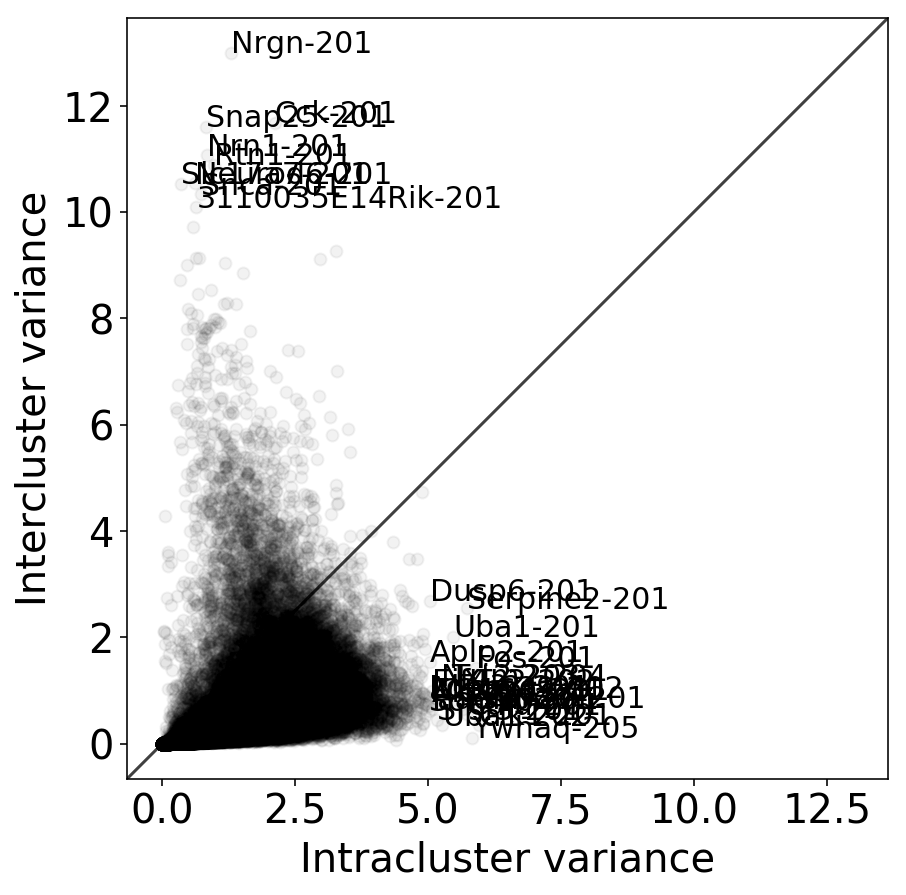

In [164]:
fig, ax = plt.subplots(figsize=(7,7))

x = mean_of_var
y = var_of_mean
alpha=0.05
color="k"
xline=5
yline=10

ax.scatter(x, y, alpha=alpha, color=color)

for i, txt in enumerate(features):
    if x[i] > xline or y[i]>yline:
        ax.annotate(txt, (x[i], y[i]), fontsize=fsize-5)

ax = plot_yex(ax)
ax.set_xlabel("Intracluster variance")
ax.set_ylabel("Intercluster variance")
        
plt.show()

## Isoform level

In [158]:
%%time

mat         = isoform.layers["log1p"].todense()
components  = isoform.obs.cell_id.values
features    = isoform.var.transcript_name.values
assignments = isoform.obs.subclass_label.values

# %lprun -f dexpress dexpress(mat, components, features, assignments)
mean, var = cluster_noise(mat, components, features, assignments)

17-Feb-20 17:57:51 - 1 of 18 assignments: Astro
17-Feb-20 17:57:52 - 2 of 18 assignments: Endo
17-Feb-20 17:57:54 - 3 of 18 assignments: L2/3 IT
17-Feb-20 17:57:55 - 4 of 18 assignments: L5 ET
17-Feb-20 17:57:56 - 5 of 18 assignments: L5 IT
17-Feb-20 17:57:58 - 6 of 18 assignments: L5/6 NP
17-Feb-20 17:58:00 - 7 of 18 assignments: L6 CT
17-Feb-20 17:58:02 - 8 of 18 assignments: L6 IT
17-Feb-20 17:58:03 - 9 of 18 assignments: L6 IT Car3
17-Feb-20 17:58:04 - 10 of 18 assignments: L6b
17-Feb-20 17:58:05 - 11 of 18 assignments: Lamp5
17-Feb-20 17:58:06 - 12 of 18 assignments: Low Quality
17-Feb-20 17:58:07 - 13 of 18 assignments: Pvalb
17-Feb-20 17:58:09 - 14 of 18 assignments: SMC
17-Feb-20 17:58:11 - 15 of 18 assignments: Sncg
17-Feb-20 17:58:12 - 16 of 18 assignments: Sst
17-Feb-20 17:58:13 - 17 of 18 assignments: VLMC
17-Feb-20 17:58:14 - 18 of 18 assignments: Vip


CPU times: user 11.1 s, sys: 14.1 s, total: 25.2 s
Wall time: 26.3 s


In [159]:
mean_of_var = np.mean(var, axis=0)
var_of_mean = np.var(mean, axis=0)

17-Feb-20 18:00:08 - update_title_pos
17-Feb-20 18:00:09 - update_title_pos
17-Feb-20 18:00:10 - update_title_pos
17-Feb-20 18:00:10 - update_title_pos


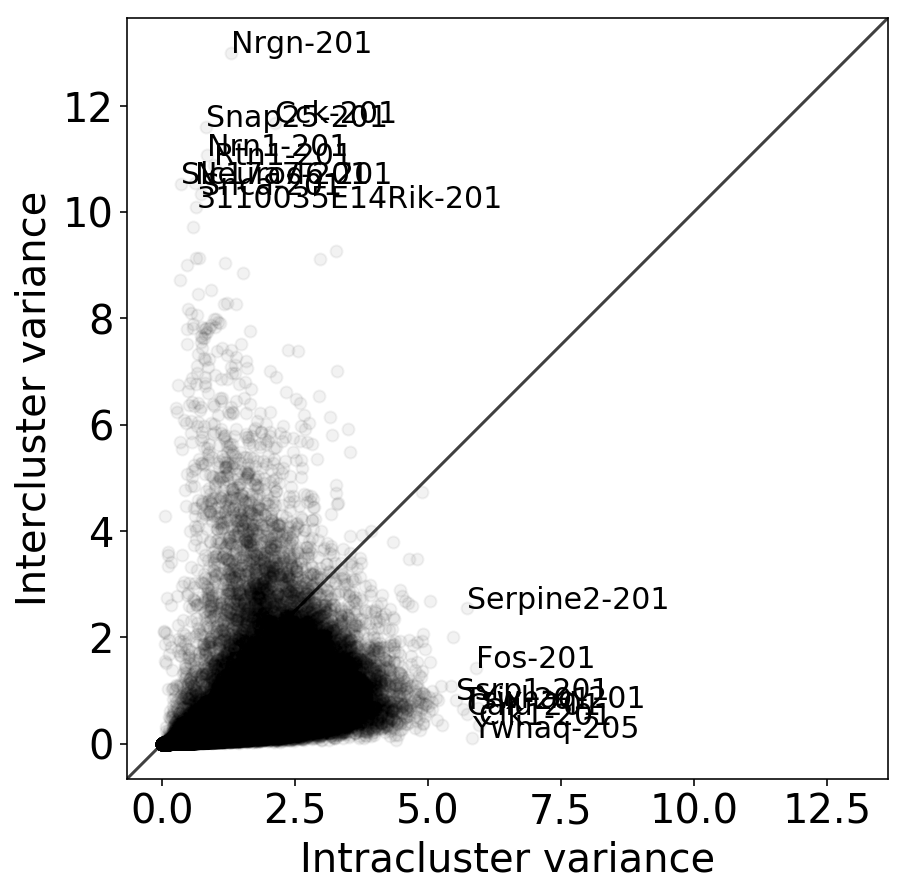

In [163]:
fig, ax = plt.subplots(figsize=(7,7))

x = mean_of_var
y = var_of_mean
alpha=0.05
color="k"
xline=5.5
yline=10

ax.scatter(x, y, alpha=alpha, color=color)

for i, txt in enumerate(features):
    if x[i] > xline or y[i]>yline:
        ax.annotate(txt, (x[i], y[i]), fontsize=fsize-5)

ax = plot_yex(ax)
ax.set_xlabel("Intracluster variance")
ax.set_ylabel("Intercluster variance")
        
plt.show()